![image](https://www.ewatercycle.org/assets/logo.png)

# Case study 2: replace subbasin in PCRGlobWB2.0 with a MARRMoT model
This notebooks demonstrates how to use eWaterCycle to combine the output of two very different models in a single experiment. We run PCRGlobWB2.0 for the Rhine basin, but we replace the Moselle sub-basin with a MARRMoT model.

PCRGlobWB2.0 (Edwin 20XX) is a distributed model written in python and MARRMoT (Knoben 20XX) is a suite of conceptual models written in Matlab. To make the difference as large as possible, we choose the simplest model available within MARRMoT: the m01, a single leaky bucket.

This example use case assumes that the ewatercycle platform has been installed and configured on your system. See our [system setup documentation](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) for instructions if this is not the case.

## Import statements
We'll be using the following modules

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import logging

logging.getLogger("esmvalcore").setLevel(logging.WARNING)

import ewatercycle.analysis
import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.observation.grdc
import ewatercycle.parameter_sets
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from cartopy import crs
from cartopy import feature as cfeature
from cartopy.io import shapereader

## List of files created for this experiment

### for PCRGlobWB2.0

- `rhine_05min_era5.ini` This file is identical to the file with the same name used in the big comparison study. The only difference is that the time period (variables startTime and endTime) have been set to 2002-01-01 and 2002-12-31 respectivly. 
- `rhine_05min_era5_without_moselle.ini` This file is identical to rhine_05in_era5.ini with the only exception that the landmask variable points to no_moselle_landmask_05min_rhine.map in the input directory
- `no_moselle_landmask_05min_rhine.map` This file is based on rhine_05min.map. Using a shape file with the shape of the Moselle catchment (see MARRMoT below) all pixels that are part of the moselle catchment have been removed (set to zero) in this landmask.

### for MARRMoT

- `marrmot_ERA5_Moselle_2001_2016.mat` This file contains the forcing that MARRMoT needs to run. It was created by running the ESMVAlTool recipe (TODO Jerom to provide details)

## Settings and parameters to run this experiment
The settings below are seperated in settings that 'belong' to the experiment, those that belong to PCRGlobWB or those that belong with MARRMoT

In [2]:
# Settings for this experiment

# The project home directory where data lives and output should be written
PROJECT_HOME = "/mnt/home/user36/temp/Case1"
DATA_HOME = "/mnt/data/examples/technical_paper"

# Settings for GRDC station for final comparison of streamflow
station_id = "6335020"  # GRDC station ID
basin_name = "Rhine"

# Location of the mouth of the Moselle.
lat_moselle_mouth = [50.366852]
lon_moselle_mouth = [7.609666]

The closest PCRGlobWB pixel to this location will be used to 'dump' the output of MARRMoT into the 'channel_storage' of PCRGlobWB. Location from Google maps.

In [3]:
# Settings for PCRGlobWB2.0
pcrglob_input_dir = DATA_HOME + "/pcr-globwb/input"

pcrglob_ref_setting_file = PROJECT_HOME + "/settingFiles/rhine_05min_era5.ini"
pcrglob_exp_setting_file = (
    PROJECT_HOME + "/settingFiles/rhine_05min_era5_without_moselle.ini"
)

In [4]:
# Settings for MARRMoT

# forcing dataset and directory
marrmot_forcing_dir = DATA_HOME + "/marrmot/marrmotForcing/validation"
marrmot_forcing_file = "marrmot_ERA5_Moselle_2001_2016.mat"

# shape file that was used to delineate the catchment, is needed here to calculate area
shapefile = DATA_HOME + "/marrmot/marrmotForcing/Moselle.shp"

spinup_start_date = "2001-01-01T00:00:00Z"
spinup_end_date = "2001-12-31T00:00:00Z"
start_date = "2002-01-01T00:00:00Z"
end_date = "2002-12-31T00:00:00Z"

# variable of interest to get out of the model
marrmot_output_variable = "flux_out_Q"

# flux_out_Q unit conversion factor from mm/day to m3/s
conversion_mmday2m3s = 1 / (1000 * 86400)

# parameters, in this case max soil moisture storage (in mm), ranging between 100 en 2000
# https://github.com/wknoben/MARRMoT/blob/dev-docker-BMI/MARRMoT/Models/Parameter%20range%20files
maximum_soil_moisture_storage = 1500.0
initial_soil_moisture_storage = 0.9 * maximum_soil_moisture_storage

## Derived directories and constants


In [5]:
# project directories for model input i.e. shape files and forcing
shape = shapereader.Reader(shapefile)
record = next(shape.records())
moselle_area = record.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", moselle_area)

The catchment area is: 28101200000.0


## Setting up the model objects
For MARRMoT we first need to generate a config file. After that is done, the three BMI model objects are created

In [6]:
marrmot_forcing = ewatercycle.forcing.load_foreign(
    target_model="marrmot",
    directory=marrmot_forcing_dir,
    start_time=spinup_start_date,
    end_time=end_date,
    forcing_info={"forcing_file": marrmot_forcing_file},
)

In [7]:
marrmot_model = ewatercycle.models.MarrmotM01(
    version="2020.11", forcing=marrmot_forcing
)

# Create config file and write to work directory (cfg_dir)
# Start up a container for MARRMoT
marrmot_cfg_file, marrmot_cfg_dir = marrmot_model.setup(
    # No need to specifiy start and end date, using dates from forcing_output
    maximum_soil_moisture_storage=maximum_soil_moisture_storage,
    initial_soil_moisture_storage=initial_soil_moisture_storage,
)
marrmot_cfg_file, marrmot_cfg_dir

Running /mnt/data/singularity-images/ewatercycle-marrmot-grpc4bmi_2020.11.sif singularity container on port 52957


('/mnt/home/user30/technicalPaperExampleNotebooks/ewatercycle_output/marrmot_20210806_064126/marrmot-m01_config.mat',
 '/mnt/home/user30/technicalPaperExampleNotebooks/ewatercycle_output/marrmot_20210806_064126')

In [8]:
# Initialize using the created config file
marrmot_model.initialize(marrmot_cfg_file)

In [9]:
# MARRMot needs to spin-up, so we run it for a while, see the period for timing
while marrmot_model.time_as_isostr < spinup_end_date:
    marrmot_model.update()

In [10]:
pcrglob_ref_parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="reference",
    target_model="pcrglobwb",
    directory=pcrglob_input_dir,
    config=pcrglob_ref_setting_file,
    supported_model_versions={"setters"},
)

In [11]:
pcrglob_ref_model = ewatercycle.models.PCRGlobWB(
    version="setters", parameter_set=pcrglob_ref_parameter_set
)
# Start up a container for PCRGlob for the reference run
pcrglob_ref_cfg_file, pcrglob_Ref_cfg_dir = pcrglob_ref_model.setup()
pcrglob_ref_cfg_file, pcrglob_Ref_cfg_dir

Running /mnt/data/singularity-images/ewatercycle-pcrg-grpc4bmi_setters.sif singularity container on port 48649


('/mnt/home/user30/technicalPaperExampleNotebooks/ewatercycle_output/pcrglobwb_20210806_064204/pcrglobwb_ewatercycle.ini',
 '/mnt/home/user30/technicalPaperExampleNotebooks/ewatercycle_output/pcrglobwb_20210806_064204')

In [12]:
# Initialize using the setting file
pcrglob_ref_model.initialize(pcrglob_ref_cfg_file)

In [13]:
# Print available output variable names of PCRGlob model
pd.Series(sorted(pcrglob_ref_model.output_var_names))

0                   accumulated_land_surface_baseflow
1                               bare_soil_evaporation
2                                            baseflow
3                                     channel_storage
4     consumptive_water_use_for_non_irrigation_demand
                           ...                       
92                                 upper_soil_storage
93                           upper_soil_transpiration
94                      water_body_actual_evaporation
95                    water_body_evaporation_fraction
96                   water_body_potential_evaporation
Length: 97, dtype: object

In [14]:
pcrglob_exp_parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="experiment",
    target_model="pcrglobwb",
    directory=pcrglob_input_dir,
    config=pcrglob_exp_setting_file,
    supported_model_versions={"setters"},
)

In [15]:
# Start up a container for PCRGlob for the experiment run
pcrglob_exp_model = ewatercycle.models.PCRGlobWB(
    version="setters", parameter_set=pcrglob_exp_parameter_set
)
# Start up a container for PCRGlob for the reference run
pcrglob_exp_cfg_file, pcrglob_exp_cfg_dir = pcrglob_exp_model.setup()
pcrglob_exp_cfg_file, pcrglob_exp_cfg_dir

Running /mnt/data/singularity-images/ewatercycle-pcrg-grpc4bmi_setters.sif singularity container on port 57727


('/mnt/home/user30/technicalPaperExampleNotebooks/ewatercycle_output/pcrglobwb_20210806_064314/pcrglobwb_ewatercycle.ini',
 '/mnt/home/user30/technicalPaperExampleNotebooks/ewatercycle_output/pcrglobwb_20210806_064314')

In [16]:
# Initialize using the setting file
pcrglob_exp_model.initialize(pcrglob_exp_cfg_file)

### Import GRDC observations

Read the GRDC data for the period of the experiment, for the station given above.

In [17]:
observations_df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id,
    start_time=start_date,
    end_time=end_date,
)
grdc_obs = observations_df.rename(columns={"streamflow": "Observations from GRDC"})
grdc_lon = metadata["grdc_longitude_in_arc_degree"]
grdc_lat = metadata["grdc_latitude_in_arc_degree"]

GRDC station 6335020 is selected. The river name is: RHINE RIVER.The coordinates are: (51.756918, 6.395395).The catchment area in km2 is: 159300.0. There are 0 missing values during 2002-01-01T00:00:00Z_2002-12-31T00:00:00Z at this station. See the metadata for more information.


The GRDC station in the PCRGlobWB grid is one pixel below the river. So we correct the location.

In [18]:
gridded_grdc_lat = grdc_lat - 0.05
gridded_grdc_lon = grdc_lon

## Running the experiment
With all pieces in place, we can now start to run the actual experiment. Each timestep first the reference model (PCRGlobWB 2.0 with the Moselle) is run and it's output stored. Subsequently, MARRMoT is run, it's output is stored and it is added to the experiment model (PCRGlobWB 2.0 without the Moselle). Than, finally, the experiment model is run for one timestep, it's output stored and we go on to the next timestep.

In [19]:
# Create variables needed during the experiment run
time_range = []
pcrglob_ref_output = []
pcrglob_exp_output = []
marrmot_output = []

In [20]:
print(f"Running experiment", flush=True)

# the experiment model is used as central 'time keeper'
while pcrglob_exp_model.time < pcrglob_exp_model.end_time:
    print(f"Current time: {pcrglob_exp_model.time_as_isostr}", end="\r")
    time_range.append(pcrglob_exp_model.time_as_datetime.date())

    # run the reference model for one timestep, store the output at grdc station
    pcrglob_ref_model.update()
    pcrglob_ref_discharge = pcrglob_ref_model.get_value_at_coords(
        "discharge", lat=[gridded_grdc_lat], lon=[gridded_grdc_lon]
    )[0]
    pcrglob_ref_output.append(pcrglob_ref_discharge)

    # run MARRMoT and store the output, note that MARRMoT output is in mm!
    marrmot_model.update()
    marrmot_output.append(marrmot_model.get_value(marrmot_output_variable)[0])

    # add the output of MARRMoT to PCRGlob Experiment model. Note that channel storage
    # is in m3, while MARRMoT output is in mm, so we need to convert
    water_to_add_to_pcrglob = marrmot_output[-1] * moselle_area / 1000  
    current_value_in_pcrglob = pcrglob_exp_model.get_value_at_coords(
        "channel_storage", lat=[lat_moselle_mouth], lon=[lon_moselle_mouth]
    )
    value_to_set_in_pcrglob = water_to_add_to_pcrglob + current_value_in_pcrglob
    pcrglob_exp_model.set_value_at_coords(
        "channel_storage",
        lat=[lat_moselle_mouth],
        lon=[lon_moselle_mouth],
        values=value_to_set_in_pcrglob,
    )

    # Run the experiment PCRGlobWB model one timestep, store the output at grdc station
    pcrglob_exp_model.update()
    pcrglob_exp_discharge = pcrglob_exp_model.get_value_at_coords(
        "discharge", lat=[gridded_grdc_lat], lon=[gridded_grdc_lon]
    )[0]
    pcrglob_exp_output.append(pcrglob_exp_discharge)

print("")

Running experiment
Current time: 2002-12-30T00:00:00Z


In [21]:
# Capture all discharge of last timestep of experiment
data_exp_last = pcrglob_exp_model.get_value_as_xarray("discharge")

### clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [22]:
pcrglob_ref_model.finalize()

In [23]:
pcrglob_exp_model.finalize()

In [24]:
marrmot_model.finalize()

Combine values of each time step into single dataset

In [25]:
data_exp_at_grdc_location = pd.DataFrame(
    {"PCRGlobWB Moselle replaced by MARRMoT-m01": pcrglob_exp_output},
    index=pd.to_datetime(time_range),
)
data_ref_at_grdc_location = pd.DataFrame(
    {"PCRGlobWB normal": pcrglob_ref_output}, index=pd.to_datetime(time_range)
)

In [26]:
# Store results on disk
data_exp_at_grdc_location.to_csv(pcrglob_exp_cfg_dir + '/data_exp.csv')
data_ref_at_grdc_location.to_csv(pcrglob_Ref_cfg_dir + '/data_ref.csv')
data_exp_last.to_netcdf(pcrglob_exp_cfg_dir + '/data_exp_last.nc')

In [27]:
# Retrieve results from disk when models are run in seperate session, adjust paths to previous run
# data_exp_at_grdc_location = pd.read_csv('/mnt/home/user36/temp/Case1/pcrglobwb_20210426_100036/data_exp.csv', index_col=0, parse_dates=True)
# data_ref_at_grdc_location = pd.read_csv('/mnt/home/user36/temp/Case1/pcrglobwb_20210426_095636/data_ref.csv', index_col=0, parse_dates=True)
# data_exp_last = xr.open_dataset('/mnt/home/user36/temp/Case1/pcrglobwb_20210426_100036//data_exp_last.nc')

## Plot the results

First we draw a map of the discharge at the final timestep of the model run. We add a blue dot at the location of the GRDC observation gauge and we add the shape of the Moselle sub-basin as well.

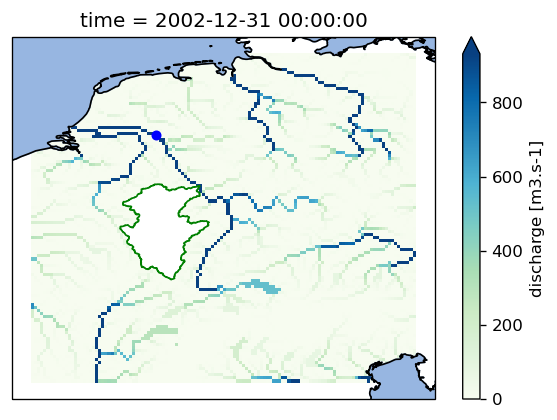

In [28]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Add the mosell catchment to the map
ax.add_feature(
    cfeature.ShapelyFeature(
        shape.geometries(),
        crs.PlateCarree(),
        edgecolor="green",
        facecolor="none",
    )
)

# Plotting the model field is a one-liner
data_exp_last.plot(ax=ax, cmap="GnBu", robust=True)

# Also plot the station location
ax.scatter(grdc_lon, grdc_lat, s=25, c="b")
# TODO plot the grid cell of model for which hydrograph is made
# ax.scatter(model_longitude, model_latitude, s=25, c='r')

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.coastlines(zorder=3)
fig.savefig(f"pcrglobwb_RolfTestRhine_discharge_map", bbox_inches="tight", dpi=300)

In [29]:
# Combine timeseries of ERA-Interim, ERA5 and GRDC observations in a pandas dataframe
df = data_exp_at_grdc_location.join(data_ref_at_grdc_location).join(grdc_obs)

(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

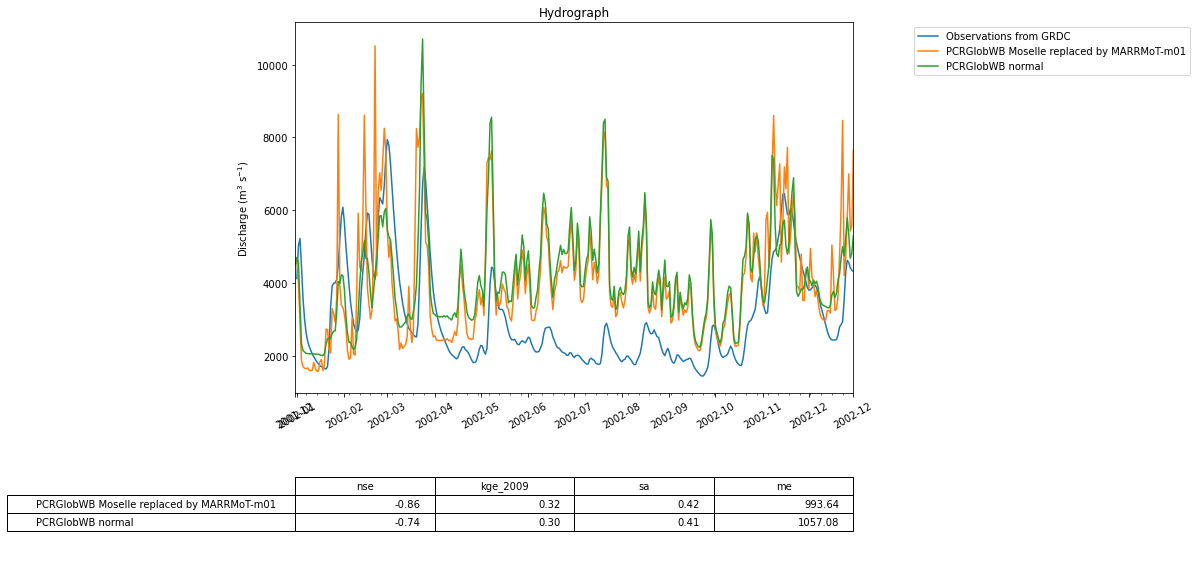

In [30]:
ewatercycle.analysis.hydrograph(
    discharge=df,
    reference="Observations from GRDC",
    filename="case2CouplingModels",
)